# Model Explainablility

Machine Learning is often seen as black boxes that are difficult to interpret. However, there are techniques that help explain what a model is doing overall, and for specific observations

- Being able to interpret a model increases trust in a machine learning model. 
- To detect if there is any bias present in the model
- Model Explainability is critical for getting models to vet by regulatory authorities


## Techniques:

- SHAP
- LIME
- PDP : partial dependence plot


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import catboost as cb
sns.set(style='ticks')

In [34]:
# train an XGBoost model
X, y = shap.datasets.boston()

In [35]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

### Data:

X:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate
- PTRATIO - pupil-teacher ratio by town
- B proportion of blacks by town
- LSTAT - % lower status of the population

y:
- MEDV - Median value of owner-occupied homes in $1000's

In [25]:
model = cb.CatBoostRegressor(verbose = False).fit(X, y)

In [37]:
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [36]:
y[0:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

#### SHAP:

https://github.com/slundberg/shap


In [ ]:
### explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [26]:
print(shap_values.shape) # (8658, 3)
print(shap_values.shape == X.shape) # True
print(type(shap_values))

(506, 13)
True
<class 'shap._explanation.Explanation'>


## Local Interpretability

### SHAP visualize

- Waterfall plots show how the SHAP values move the model prediction from the expected value E[f(X)] displayed at the bottom of the chart to the predicted value f(x) at the top. 

- Sorted with the smallest SHAP values at the bottom. 

- Red : increase the predicted value

- Blue : decrease the predicted value

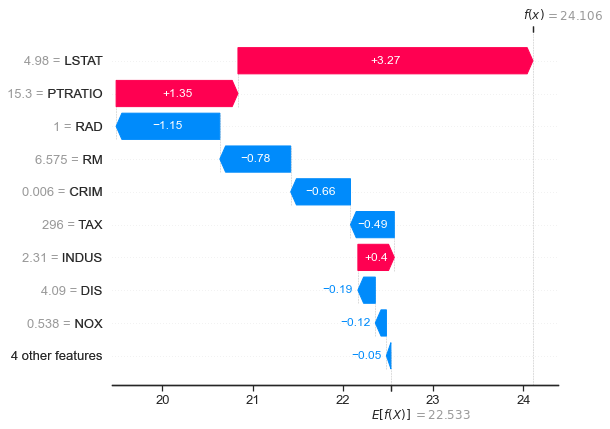

In [25]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### SHAp Value interpretation 

- LSTSAT, PTRATIO, INDUS have a positive impact on value

- Other variables (RAD, RM, etc) decrease the predicted value

### shap_values:
- .values – the SHAP values themselves, 
- .base_values – the average prediction for our model, and 
- .data – the original X data

In [27]:
print(shap_values[0])

.values =
array([-0.66251056, -0.00392228,  0.40355825, -0.05536468, -0.12321204,
       -0.7848814 ,  0.07068722, -0.19300514, -1.1491306 , -0.48545192,
        1.34975916, -0.06114744,  3.2680295 ])

.base_values =
22.532735101599286

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])


#### Adding SHAP values together is one of their key properties and is one reason they are called Shapley additive explanations.

In [119]:
# Adding shap value with Base value = Actual value 
22.532735101599286 -0.66251056 -0.00392228 +  0.40355825  -0.05536468 -0.12321204 -0.7848814 + 0.07068722  -0.19300514 -1.1491306  -0.48545192 + 1.34975916 -0.06114744 +  3.2680295

24.10614317159929

### Tree Explainer

In [46]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [47]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

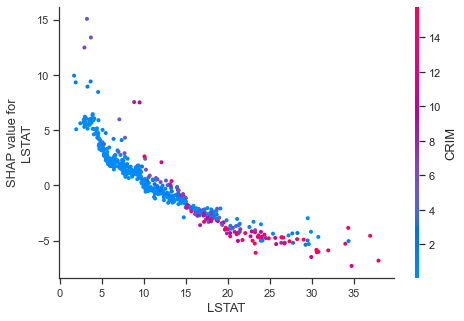

In [48]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
# take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally
shap.dependence_plot("LSTAT", shap_values, X)

## Global Interpretability

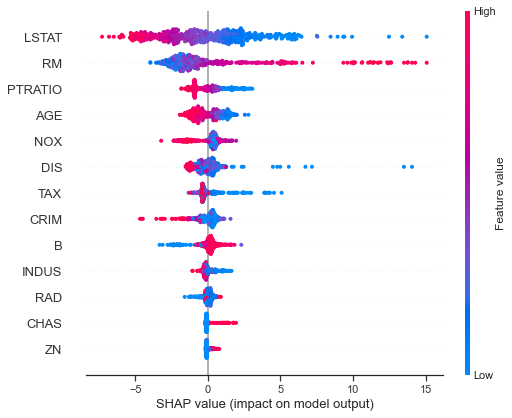

In [43]:
shap.summary_plot(shap_values, X)

# LIME - Local interpretability

In [57]:
import lime
import lime.lime_tabular

In [63]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(X), feature_names=X.columns, 
                                              class_names=y,
                                              mode='regression')

In [66]:
exp = explainer.explain_instance(data_row=X.iloc[0], 
                                 predict_fn=model.predict)

exp.show_in_notebook(show_table=True)

In [65]:
exp = explainer.explain_instance(data_row=X.iloc[1], 
                                 predict_fn=model.predict)

exp.show_in_notebook(show_table=True)

# Partial Dependence Plot

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model


Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.


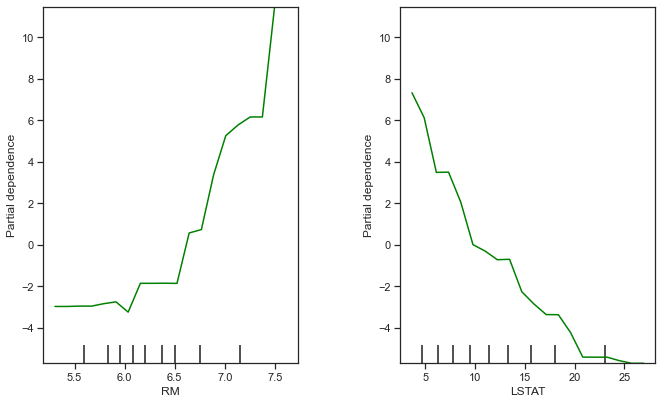

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
my_model = GradientBoostingRegressor()
# fit the model as usual
my_model.fit(X, y)
X_colns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']
my_plots = plot_partial_dependence(my_model,       
                                   features=[5,12], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=X_colns, # labels on graphs
                                   grid_resolution=20)